COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – 500543568

Note on imports:
- You are NOT allowed to use Deep Learning frameworks (e.g. PyTorch, Tensorflow, Caffe, and KERAS), or any kinds of auto-grad tools (e.g. autograd).
- Scientific computing packages, such as NumPy and SciPy, are acceptable. 

Note on code sources:
- Week 3: activation function, hidden layers, MLP
- Week 4: momentum, AdaGrad, Adam, SGD
- Week 5: dropout, batch normalization

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data loading
train_data = np.load('Assignment1-Dataset/train_data.npy')
train_label = np.load('Assignment1-Dataset/train_label.npy')
test_data = np.load('Assignment1-Dataset/test_data.npy')
test_label = np.load('Assignment1-Dataset/test_label.npy')

#min max
train_min = np.min(train_data)
train_max = np.max(train_data)

adj_train_data = (train_data - train_min) / (train_max - train_min)
adj_test_data = (test_data - train_min) / (train_max - train_min)

#to consider: PCA for dimensionality reduction, which may or may not be beneficial in NN

In [3]:
# data size scaler
# this is intended to help with initial build (e.g. rather than going through 50k of datapoints, we go through factor * 50k)

def create_smaller_dataset(train_data, train_label, n, random_state = None):
    smaller_data = []
    smaller_label = []
    
    unique_labels = np.unique(train_label)

    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(train_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(n*len(label_indices)), replace=False)
        
        smaller_data.extend(train_data[selected_indices])
        smaller_label.extend(train_label[selected_indices])
    
    smaller_data = np.array(smaller_data)
    smaller_label = np.array(smaller_label)

    print('random_state:', random_state)
    print("Shape of input_data:", smaller_data.shape)
    print("Shape of output_data:", smaller_label.shape)
    
    return smaller_data, smaller_label


In [4]:
# all classes are contained here

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #added in: ReLu

    def __relu(self, x):
        return np.maximum(0,x)

    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #added in: softmax

    def __softmax(self,x): #recheck this
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        return exps / np.sum(exps, axis =-1, keepdims = True)

    def __softmax_deriv(self,a):
        return a * (1-a) #this derivative is wrong but it doesn't matter since softmax is in output layer, and no derivative will be calc'ed

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

class HiddenLayer(object):    
    def __init__(self,n_in, n_out,
                 activation_last_layer='tanh',activation='tanh', W=None, b=None):
        """
        Typical hidden layer of a MLP: units are fully-connected and have
        sigmoidal activation function. Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        NOTE : The nonlinearity used here is tanh

        Hidden unit activation is given by: tanh(dot(input,W) + b)

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden
                           layer
        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        # if activation == 'logistic':
        #     self.W *= 4

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    #updated to handle softmax at output layer
    def backward(self, delta, output_layer=False):         

        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) # summing the values to match dimension with self.b
        #if self.activation_deriv and not output_layer:
        if self.activation_deriv: #need to check, do we need to account for output_layer=True
            #print('shape of delta:',delta.shape)
            #print('shape of W:',self.W.shape)
            #print('shape of transposed W:', self.W.T.shape)
            #print('shape of activation_deriv',self.activation_deriv(self.input))
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

        return delta
    
class MLP:
    """
    """ 

    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                #print("Hidden Layer", i+1, "Weight Shape:", hidden_layer.W.shape)
                #print("Hidden Layer", i+1, "Bias Shape:", hidden_layer.b.shape)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                #print("Hidden Layer", i+1, "Weight Shape:", hidden_layer.W.shape)
                #print("Hidden Layer", i+1, "Bias Shape:", hidden_layer.b.shape)
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input)
            input=output
        return output

    # define the objection/loss function, we use mean sqaure error (MSE) as the loss
    # you can try other loss, such as cross entropy.
    # when you try to change the loss, you should also consider the backward formula for the new loss as well!
    def criterion_MSE(self,y,y_hat):
        activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat
        loss=error**2
        # calculate the MSE's delta of the output layer
        delta=-error*activation_deriv(y_hat)    
        # return loss and delta
        return loss,delta

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat):
        num_samples = y.shape[0]
        #print(y_hat.shape)
        num_classes = y_hat.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) #need one hot encode for softmax calculation
        y_one_hot[np.arange(num_samples),y.flatten()] = 1

        error = np.sum(- y_one_hot * np.log(y_hat + 1e-9)) #epsilon added to avoid log 0
        delta = y_hat - y_one_hot
        return error, delta

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta,output_layer=True)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta=layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!  
    # note: added assert for debugging  
    def update(self,lr):
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, 'mismatch in W and grad_W shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X,y,learning_rate=0.1, epochs=100):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X=np.array(X)
        y=np.array(y)
        to_return = np.zeros(epochs)
        
        for k in range(epochs):
            loss=np.zeros(X.shape[0])
            for it in range(X.shape[0]):
                i=np.random.randint(X.shape[0])
                
                # forward pass
                y_hat = self.forward(X[i])
                
                # backward pass
                #loss[it],delta=self.criterion_MSE(y[i],y_hat)
                loss[it],delta=self.criterion_cross_entropy(y[i],y_hat)
                
                #backward pass
                self.backward(delta)
                
                # update
                self.update(learning_rate)
            to_return[k] = np.mean(loss)
        return to_return

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        '''adjusted to account for softmax output layer'''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :])  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output

In [5]:
# RUNNER

# pick data proportion and random state
data_proportion = 1
random_state = 42
input_data, output_data = create_smaller_dataset(adj_train_data, train_label, data_proportion, random_state = random_state)

# fit model
nn = MLP([128,64,10], [None,'relu','softmax'])
lr = 0.001
epoch_count = 500

# calculate cross entropy
cross_entropy = nn.fit(input_data, output_data, learning_rate = lr, epochs = epoch_count)
print('loss:%f'%cross_entropy[-1])

# predict output
output = nn.predict(input_data)

random_state: 42
Shape of input_data: (50000, 128)
Shape of output_data: (50000, 1)
loss:1.540096


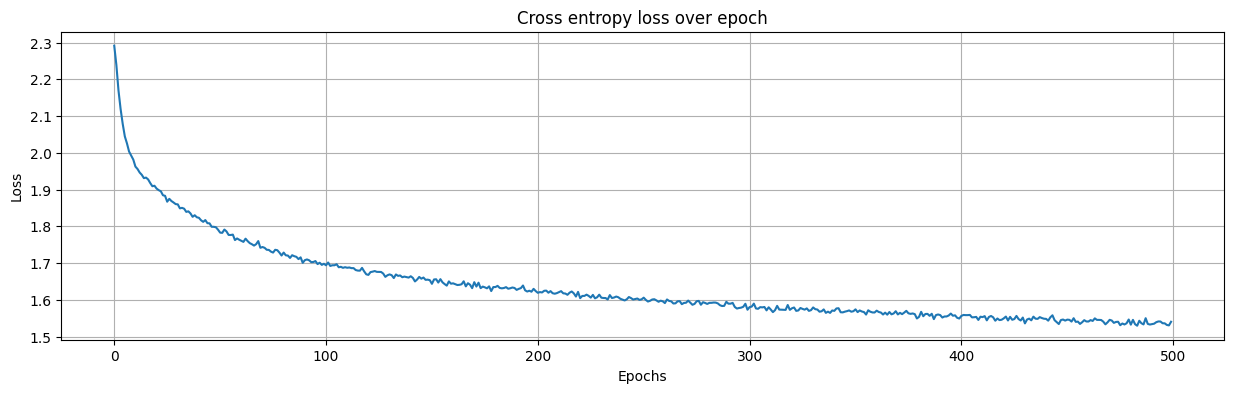

In [6]:
#plot loss
plt.figure(figsize=(15,4))
plt.title('Cross entropy loss over epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(cross_entropy)
plt.grid()

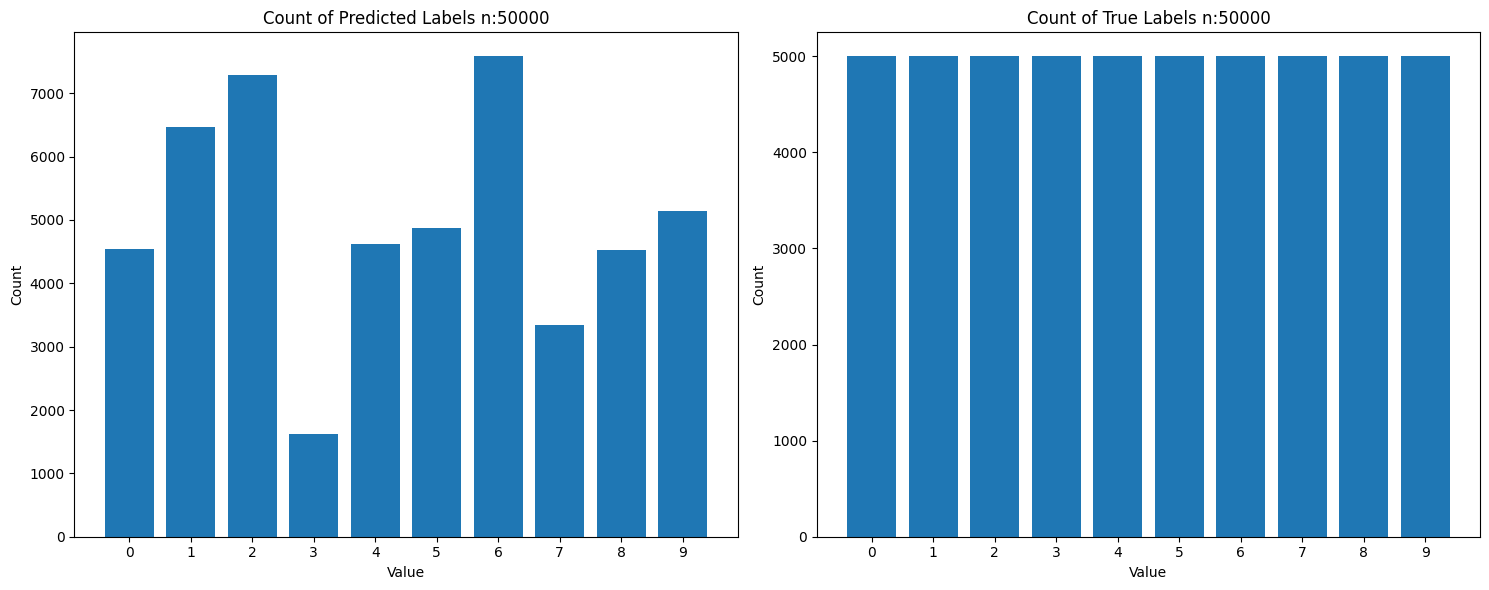

In [7]:
# plot prediction
output_unique_values, output_counts = np.unique(output, return_counts=True)
true_label_unique_values, true_label_counts = np.unique(output_data, return_counts=True)

# Set up the matplotlib figure and axes, one for each bar chart
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot for 'output'
axs[0].bar(output_unique_values, output_counts)
axs[0].set_xticks(output_unique_values)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Count')
axs[0].set_title(f'Count of Predicted Labels n:{len(output)}')

# Plot for 'true_label'
axs[1].bar(true_label_unique_values, true_label_counts)
axs[1].set_xticks(true_label_unique_values)
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Count')
axs[1].set_title(f'Count of True Labels n:{len(output_data)}')

plt.tight_layout()  # Adjust the layout to fit both subplots
plt.show()

##COMPONENT CHECKERS

In [9]:
#Forward pass checker
nn_simple = MLP([128,64,10], [None,'relu','softmax'])
simple_input = np.array([input_data[0]])
simple_output = np.array([output_data[0]])

simple_pred = nn_simple.forward(simple_input)
print("Forward pass output:", simple_pred)

Forward pass output: [[0.11170962 0.06885336 0.18158021 0.05877137 0.05953147 0.15483647
  0.13791824 0.0657021  0.12172446 0.03937271]]


In [10]:
# Gradient checker
# Assuming a simple loss (manually set) for demonstration
simple_loss = np.random.rand(10).reshape(1,-1)  # Random loss gradients
nn_simple.backward(simple_loss)

# Check the gradients
for i, layer in enumerate(nn_simple.layers):
    print(f"Layer {i} grad_W min: {np.min(layer.grad_W)}, max: {np.max(layer.grad_W)}")

Layer 0 grad_W min: -0.4788894537780415, max: 0.42550447504371425
Layer 1 grad_W min: 0.0, max: 0.963953431415622


In [11]:
# Weight update checker
print("Weights before update:", nn_simple.layers[0].W)
nn_simple.update(0.01)  # Using a learning rate of 0.01
print("Weights after update:", nn_simple.layers[0].W)

Weights before update: [[ 0.07926984 -0.05142857 -0.01525231 ...  0.01553553  0.09318075
   0.07755901]
 [-0.0621108  -0.02998801 -0.01417228 ... -0.02201418 -0.13874681
   0.10614979]
 [ 0.00779875  0.09406362  0.1279343  ...  0.02115517  0.09711226
  -0.17088307]
 ...
 [ 0.03027775  0.01242745 -0.08407855 ... -0.02112407 -0.08544915
   0.02345424]
 [ 0.03581534 -0.10593576  0.15688311 ...  0.08989325  0.02277545
  -0.10167835]
 [ 0.1352229  -0.10352272  0.04112307 ... -0.10922624 -0.08065485
  -0.04712463]]
Weights after update: [[ 0.08109797 -0.05187612 -0.01547948 ...  0.01508612  0.09318075
   0.07755901]
 [-0.06120371 -0.03021008 -0.014285   ... -0.02223717 -0.13874681
   0.10614979]
 [ 0.00895764  0.0937799   0.12779029 ...  0.02087028  0.09711226
  -0.17088307]
 ...
 [ 0.03145842  0.01213841 -0.08422526 ... -0.02141432 -0.08544915
   0.02345424]
 [ 0.03697416 -0.10621945  0.15673911 ...  0.08960838  0.02277545
  -0.10167835]
 [ 0.13637754 -0.10380539  0.04097958 ... -0.10951008